<a href="https://colab.research.google.com/github/vsoos/CloudComputing/blob/main/ex4/4_notebook1_cpu/4_1_cpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
folder_path = "/content/drive/MyDrive/cloudcomputing2023_VincenzinaSoos/ex4/4_notebook1_cpu"
os.chdir(folder_path)

In [4]:
df = pd.read_csv("data/tmdb_5000_movies.csv")

In [5]:
df.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800


In [8]:
# extract genre names from dicts
def extract_genre_names(genre_list):
    genres = [] # grab names only
    for genre in genre_list:
        genres.append(genre['name'])
    return genres

In [25]:
# Most popular Movie Genres
df_copy = df.copy()
# parse genres column
# json string -> python list
df_copy['genres'] = df_copy['genres'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

# apply to genres column
# keep only names
df_copy['genres'] = df_copy['genres'].apply(lambda x: extract_genre_names(x) if isinstance(x, list) else x)

# flatten genres
# count genre occurrences
genre_counts = df_copy['genres'].explode().value_counts()

# sort genre counts descending
genre_counts_sorted = genre_counts.sort_values(ascending=False)

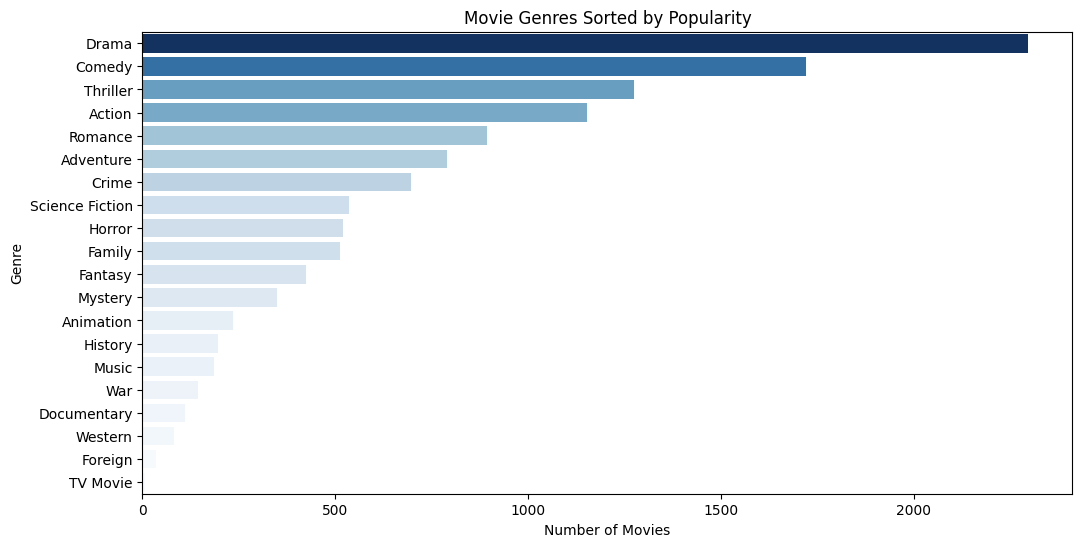

In [12]:
# plot bar chart for genres (saturated to non-saturated)
normalized_popularity = (genre_counts_sorted.values - np.min(genre_counts_sorted.values)) / (np.max(genre_counts_sorted.values) - np.min(genre_counts_sorted.values))
colors = [plt.cm.Blues(val) for val in normalized_popularity]
data = pd.DataFrame({
    'Genre': genre_counts_sorted.index,
    'Popularity': genre_counts_sorted.values,
    'Color': normalized_popularity
})

plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Popularity', y='Genre', hue='Genre', dodge=False, palette=colors,legend=False)
plt.title('Movie Genres Sorted by Popularity')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()

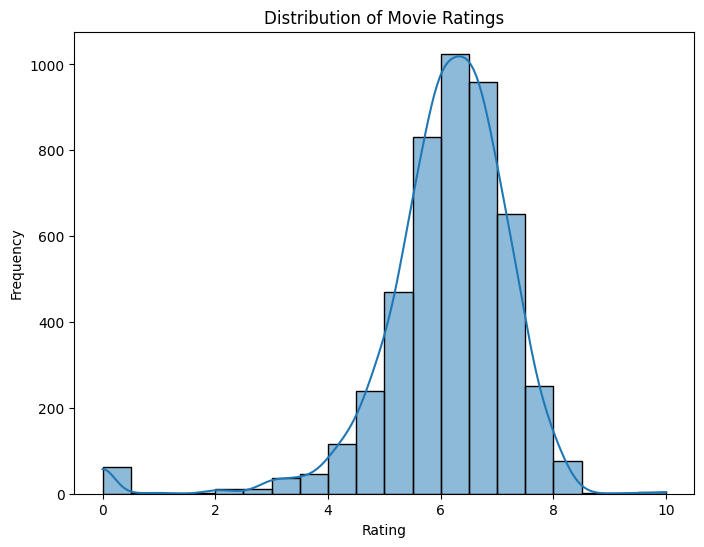

In [13]:
# Movie ratings
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='vote_average', bins=20, kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

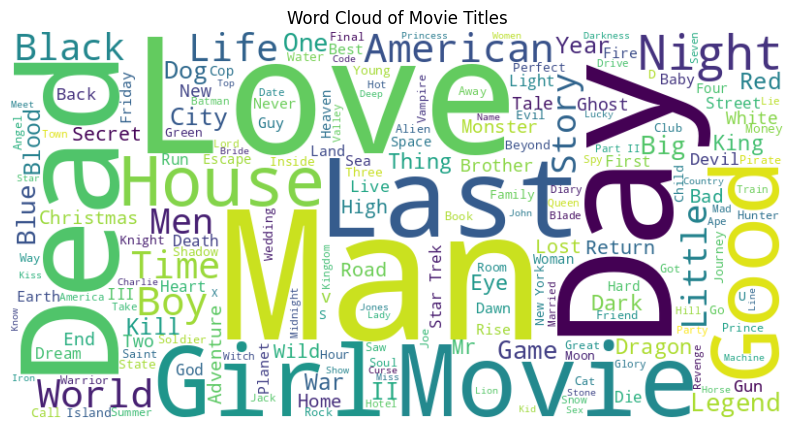

In [14]:
# word cloud
movie_titles = ' '.join(df['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(movie_titles)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Movie Titles')
plt.axis('off')
plt.show()

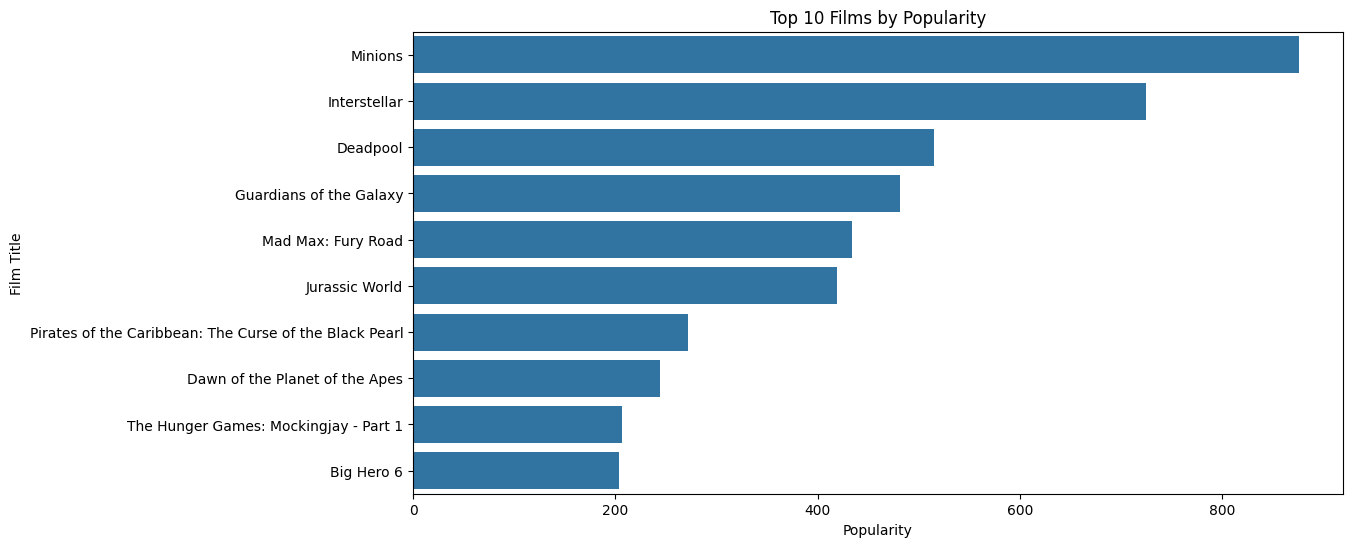

In [15]:
# top 10 movies by popularity
# sort by popularity descending
highest_popularity = df.sort_values(by='popularity', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='popularity', y='title', data=highest_popularity, orient='h')
plt.title('Top 10 Films by Popularity')
plt.xlabel('Popularity')
plt.ylabel('Film Title')
plt.show()

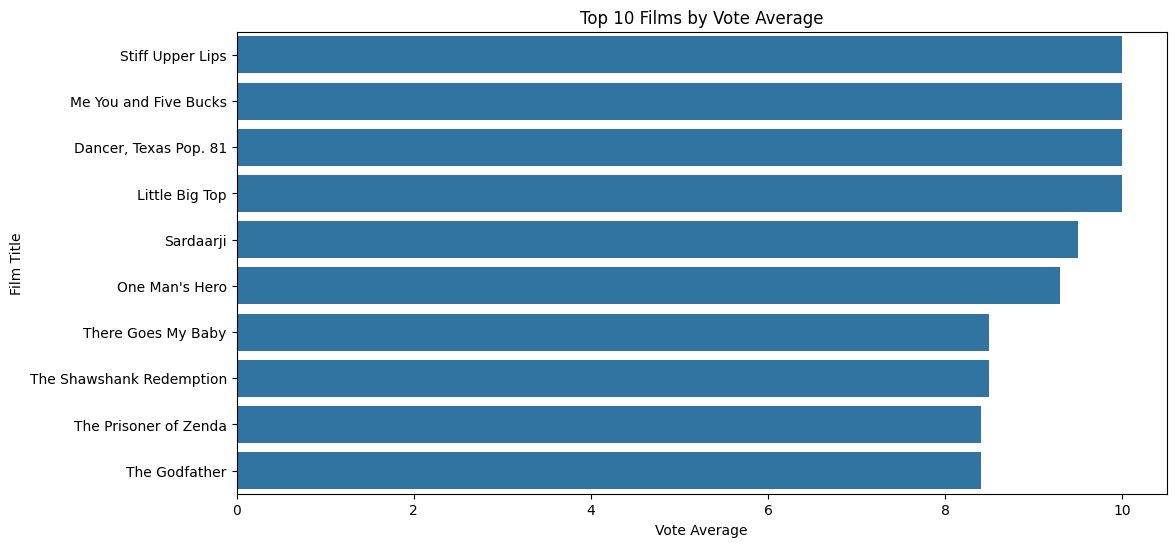

In [ ]:
# Sort by vote_average (desc, 10)
highest_vote_average = df.sort_values(by='vote_average', ascending=False).head(10)

# bar chart top 10 films by vote_average
plt.figure(figsize=(12, 6))
sns.barplot(x='vote_average', y='title', data=highest_vote_average, orient='h')
plt.title('Top 10 Films by Vote Average')
plt.xlabel('Vote Average')
plt.ylabel('Film Title')
plt.show()

In [16]:
# parse genres and keywords
# handle json/list hybrid columns
def parse_json_or_list(value):
    try:
        return json.loads(value)  # parse the input 'value' as JSON
    except (TypeError, ValueError):
        # If not valid JSON, it's a list
        return eval(value)

In [17]:
# apply json parsing
df['genres'] = df['genres'].apply(parse_json_or_list)
df['keywords'] = df['keywords'].apply(parse_json_or_list)

In [18]:
# combine genres and keywords
# into one string per row
def genres_and_keywords_to_string(row):
    genres = row['genres']
    keywords = row['keywords']

    # extract and join genres and keywords into separate strings
    genres_str = ' '.join(''.join(j['name'].split()) for j in genres)
    keywords_str = ' '.join(''.join(j['name'].split()) for j in keywords)

    # combine genres and keywords into a single string
    return f"{genres_str} {keywords_str}"

In [19]:
# add new 'string' column
df['string'] = df.apply(genres_and_keywords_to_string, axis=1)

In [21]:
# tf-idf vectorization
# convert strings -> matrix
# max features = 2000
tfidf = TfidfVectorizer(max_features=2000)
X = tfidf.fit_transform(df['string'])

In [22]:
# map titles to indices
# for fast lookups
title_to_index = pd.Series(df.index, index=df['title'])

In [23]:
# recommend movies based on a given title
def recommend(title):
    movie_id = title_to_index[title] # input: movie title
    query = X[movie_id] # find its vector
    scores = cosine_similarity(query, X) # calc cosine similarities
    scores = scores.flatten() # similarity scores to a 1D array
    recommended_movie_id = (-scores).argsort()[1:11] # return top 10 recommendations

    # Return top 10 recommended movies
    return df['title'].iloc[recommended_movie_id]

In [26]:
# movie titles to test (10)
test_movie_titles = ['Interstellar', 'Inception', 'The Dark Knight', 'Avatar',
                     'Titanic', 'The Matrix', 'Her', 'Gone Girl',
                     'Lucy', 'The Shawshank Redemption']

for input_movie_title in test_movie_titles:
    recommended_movie_titles = recommend(input_movie_title)  # Get recommendations

    # recommendations with popularity and avg vote
    print(f"\nRecommendations for '{input_movie_title}':")
    for i, movie_title in enumerate(recommended_movie_titles, start=1):
        recommended_movie = df[df['title'] == movie_title].iloc[0]
        popularity = recommended_movie['popularity']
        vote_average = recommended_movie['vote_average']
        print(f"{i}. {movie_title} (Popularity: {popularity:.2f}, Vote Average: {vote_average:.2f})")


Recommendations for 'Interstellar':
1. Apollo 13 (Popularity: 68.14, Vote Average: 7.30)
2. Silent Running (Popularity: 11.10, Vote Average: 6.30)
3. Space Cowboys (Popularity: 15.77, Vote Average: 6.30)
4. Elysium (Popularity: 67.34, Vote Average: 6.40)
5. In the Shadow of the Moon (Popularity: 3.43, Vote Average: 7.60)
6. The Martian (Popularity: 167.93, Vote Average: 7.60)
7. Oblivion (Popularity: 67.70, Vote Average: 6.40)
8. The Astronaut's Wife (Popularity: 20.70, Vote Average: 5.40)
9. 2001: A Space Odyssey (Popularity: 86.20, Vote Average: 7.90)
10. Escape from Planet Earth (Popularity: 18.14, Vote Average: 5.70)

Recommendations for 'Inception':
1. Disturbia (Popularity: 31.69, Vote Average: 6.60)
2. Takers (Popularity: 18.47, Vote Average: 6.00)
3. Show Me (Popularity: 0.23, Vote Average: 5.60)
4. Inside Man (Popularity: 45.22, Vote Average: 7.30)
5. Star Trek III: The Search for Spock (Popularity: 15.31, Vote Average: 6.40)
6. Anywhere But Here (Popularity: 8.98, Vote Avera